<a href="https://colab.research.google.com/github/AmedeeRoy/BirdDL/blob/main/mp_fcnet_10s.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dive Prediction - Deep Network

*Predicting Seabird Diving Behaviour from GPS data*

This notebook trains a neural network to predict seabirds' dives.

Networks' characteristics:

* *Trajectory window* : 300s
* *Output resolution*: 1s
* *Representation of trajectories* : Matrix Distance
* *Layers* : 1x1 convolutions

## connect to drive

In [1]:
# mount google drive
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [2]:
%cd drive/My\ Drive/

/content/drive/My Drive


## load data

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

from utils.trip import * 

In [4]:
data_train = pd.read_csv('./data/data_train.csv')
data_validation = pd.read_csv('./data/data_validation.csv')
data_test = pd.read_csv('./data/data_test.csv')

## choose window

In [5]:
class Sample(object):
    def __init__(self, ratio):
        self.ratio = ratio

    def __call__(self, sample):
        traj, dive = sample

        # change resolution
        idx = [i%self.ratio == 0 for i in range(traj.shape[1])]
        traj_new = traj[:,idx]
        dive_new = [np.max(dive[i:i+self.ratio]) for i in range(len(dive)) if i%self.ratio==0]


        return (traj_new, dive_new)

In [6]:
# Hyperparameters
resolution = 10
window = 100 * resolution
variable = ('lon', 'lat')

train_set = TrajDataSet(data_train, window, variable)
d = DistMatrix()
s = Sample(resolution)

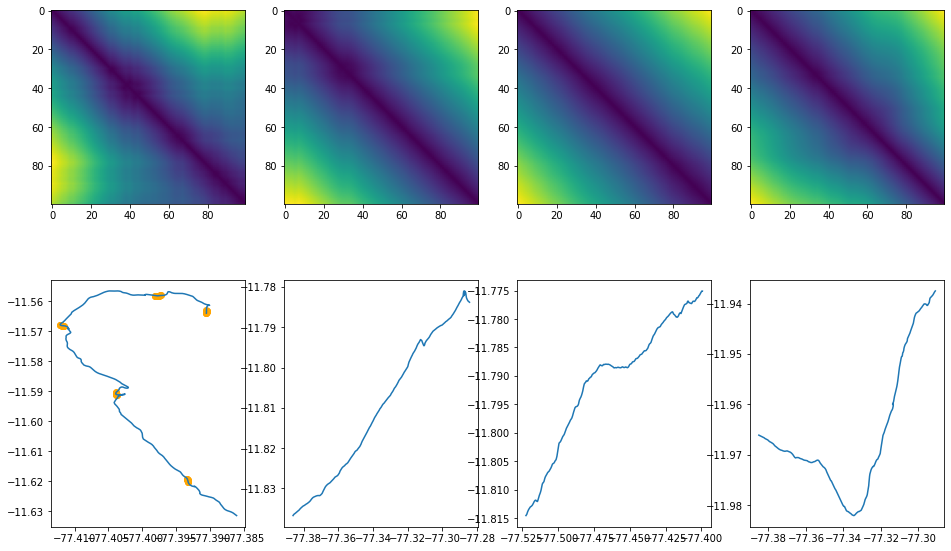

In [7]:
plt.figure(figsize=(16, 10))
idx = np.random.randint(0, len(train_set), 4)

k = -1
for i in idx:
    k += 1
    traj, dive = train_set[i]
    matrix_dist, dive = d(s(train_set[i]))
    

    plt.subplot(2,4, k+1)
    plt.imshow(matrix_dist)

    plt.subplot(2,4, k+5)
    dive = [dive[i] for i in range(len(dive)) for k in range(resolution) ]
    plt.plot(traj[0,:], traj[1,:])
    plt.scatter(traj[0, np.array(dive, dtype = 'bool')], traj[1,np.array(dive, dtype = 'bool')], c='orange')

# Neural Network

In [8]:
# hyperparameters
batch_size = 64

## reduce size dataset
train_set = TrajDataSet(data_train, window, variable, transform = transforms.Compose([Sample(resolution), DistMatrix(), ToTensor()]))
validation_set = TrajDataSet(data_validation, window, variable, transform = transforms.Compose([Sample(resolution), DistMatrix(), ToTensor()]))

train_loader = DataLoader(train_set, batch_size=batch_size, num_workers = 0, shuffle = True, drop_last=True)
validation_loader = DataLoader(validation_set, batch_size=batch_size, num_workers = 0, shuffle = True, drop_last=True)

In [9]:
class FCNet(nn.Module):

    def __init__(self):
        super(FCNet, self).__init__()

        self.threshold = nn.Sequential(
            nn.BatchNorm2d(1),
            nn.Conv2d(1, 8, kernel_size = 1, stride = 1, padding = 0, dilation = 1, bias = True),
            nn.ReLU()
        )

        self.cnn = nn.Sequential(
            nn.BatchNorm1d(8),
            nn.Conv1d(8, 4, kernel_size = 11, stride = 1, padding = 5, dilation = 1),
            nn.ReLU(),
            nn.Conv1d(4, 2, kernel_size = 11, stride = 1, padding = 5, dilation = 1),
            nn.ReLU(),
            nn.Conv1d(2, 1, kernel_size = 11, stride = 1, padding = 5, dilation = 1)
        )

    def forward(self, x):
        out = self.threshold(x)
        out = torch.sum(out, 2)
        out = self.cnn(out)

        return out


def get_score(out, y):
    out, y = out.cpu(), y.cpu()
    out = 1*(out>0)
    true_positive = np.mean(out[y == True].numpy()) 
    true_negative = 1-np.mean(out[y == False].numpy())
    
    return (round(true_positive*100) , round(true_negative*100))

In [10]:
# get sample
x, y = next(iter(train_loader)) 
weight = torch.FloatTensor([20])

# Forward model
model = FCNet()

out = model(x)

# Loss and score
learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.BCEWithLogitsLoss(pos_weight = weight)
criterion(out, y)
get_score(out, y)

(0.0, 100.0)

In [11]:
## get Loss weight
torch.sum(y==y)/torch.sum(y)

tensor(21.4765)

## Training

In [13]:
# switch to GPU
model = FCNet()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
weight = weight.to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight = weight)

In [14]:
# Train the model
nb_epoch = 3
weight = torch.FloatTensor([20])
learning_rate = 0.01

list_loss_train = []
list_score_train = []

list_loss_validation = []
list_score_validation = []


for epoch in range(nb_epoch):
    learning_rate /= 10
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    i = 0
    for batch, (x, y) in enumerate(train_loader):
        i+=1
        # send to GPU
        x, y = x.to(device), y.to(device)

        # Run the forward pass
        out = model(x)
        loss = criterion(out, y)

        # Backprop and perform optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        score = get_score(out,y)
        list_loss_train.append(loss.item())
        list_score_train.append(score)

        if (i + 1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Batch Loss: {}, Batch True Positive : {}, Batch True Negative : {} %'
                    .format(epoch+1, nb_epoch, i + 1, len(train_loader), loss.item(), score[0], score[1]))

    ### - Validation every epoch
    model.eval()
    with torch.no_grad():
        j = 0
        for batch, (x, y) in enumerate(validation_loader):
            j+= 1
            # send to GPU
            x, y = x.to(device), y.to(device)

            # Run the forward pass
            out = model(x)
            loss = criterion(out, y)
            score = get_score(out,y)
            list_loss_validation.append(loss.item())
            list_score_validation.append(score)

    global_loss = np.mean(list_loss_validation)
    global_trueP = np.mean([tp for (tp, tn) in list_score_validation])
    global_trueN = np.mean([tn for (tp, tn) in list_score_validation])

    print('Validation -------------------------------------------------------------------------------------')
    print('Epoch [{}/{}], Validation Loss: {}, Validation True Positive : {}, Validation True Negative : {} %'
            .format(epoch+1, nb_epoch, global_loss, global_trueP, global_trueN))
    print('------------------------------------------------------------------------------------------------')
    model.train()

Epoch [1/3], Step [100/1886], Batch Loss: 1.2080153226852417, Batch True Positive : 78.0, Batch True Negative : 67.0 %
Epoch [1/3], Step [200/1886], Batch Loss: 1.0197174549102783, Batch True Positive : 92.0, Batch True Negative : 66.0 %
Epoch [1/3], Step [300/1886], Batch Loss: 0.9838922023773193, Batch True Positive : 88.0, Batch True Negative : 65.0 %
Epoch [1/3], Step [400/1886], Batch Loss: 0.8720651865005493, Batch True Positive : 89.0, Batch True Negative : 68.0 %
Epoch [1/3], Step [500/1886], Batch Loss: 1.012932300567627, Batch True Positive : 92.0, Batch True Negative : 61.0 %
Epoch [1/3], Step [600/1886], Batch Loss: 0.8495533466339111, Batch True Positive : 90.0, Batch True Negative : 65.0 %
Epoch [1/3], Step [700/1886], Batch Loss: 0.9091957211494446, Batch True Positive : 90.0, Batch True Negative : 63.0 %
Epoch [1/3], Step [800/1886], Batch Loss: 0.7863218188285828, Batch True Positive : 98.0, Batch True Negative : 64.0 %
Epoch [1/3], Step [900/1886], Batch Loss: 0.75378

## Testing

In [ ]:
dive_real = []
dive_estim = []

for i in data_test.trip.unique():
    # create dataset for a trajectory
    t = data_test[data_test.trip == i].copy()    
    test_set = TrajDataSet(t, window, variable, transform = transforms.Compose([Rescale(rescale), DistMatrix(), ToTensor()]))
    test_set_part = [test_set[i] for i in range(len(test_set)) if i%rescale == 0]
    
    # Test the model
    estim = np.zeros(int((len(t))/rescale))
    nb = np.zeros(int((len(t))/rescale))
    
    list_out = []
    model.eval()
    k = 0
    with torch.no_grad():
        for (x, y) in test_set_part:
            # send to GPU
            x, y = x.to(device), y.to(device)

            # Run the forward pass
            out = model(x.unsqueeze(0))
            
            estim[k:k + round(window/rescale)] += out.cpu().squeeze().numpy()
            nb[k:k + round(window/rescale)] += 1
            k+=1

    
    # remove extra lines
    t = t.drop(t.tail(len(t)%rescale ).index)
    real = np.array([np.max(t.dive[i:i+rescale]) for i in range(len(t)) if i%rescale == 0])
    
    # add to list by trajectory
    dive_real.append(real)
    dive_estim.append(estim/nb)
    
    print(i)

P1108_46_SV_T2
P1111_41_SV_T4
P1112_10_SV_T2
P1112_15_SV_T3
P1112_20_SV_T4
P1112_31_SV_T5
P1113_28_SV_T1


In [ ]:
threshold = 0
dive_plot = np.array([1*(estim[i]>threshold)  for i in range(len(estim)) for k in range(rescale) ])

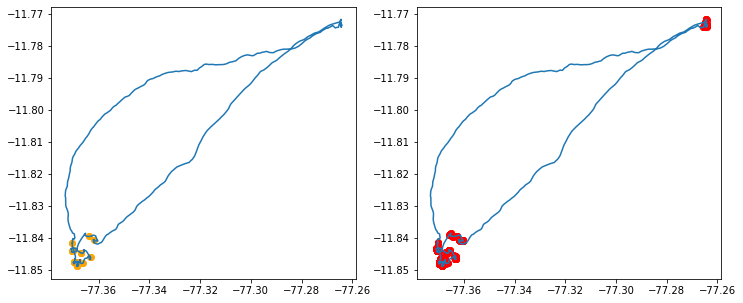

In [ ]:
plt.figure(figsize= (12, 5))
plt.subplot(1, 2, 1)
plt.plot(np.array(t.lon), np.array(t.lat))
plt.scatter(t.lon[t.dive == 1], t.lat[t.dive == 1], c = 'orange')

plt.subplot(1, 2, 2)
plt.plot(np.array(t.lon), np.array(t.lat))
plt.scatter(t.lon[dive_plot == 1], t.lat[dive_plot == 1], c = 'red')

## score

In [ ]:
# globally
all_real = 1* (np.hstack(dive_real)> 0)
all_estim = 1* (np.hstack(dive_estim) > 0)

true_positive = np.mean(all_estim[all_real == 1])
true_negative = 1-np.mean(all_estim[all_real == 0])

true_positive, true_negative

(0.7978723404255319, 0.8599148130619971)

(0.42857142857142855, 0.878099173553719)
(0.5714285714285714, 0.9233716475095786)
(0.8333333333333334, 0.9105431309904153)
(0.875, 0.7591036414565826)
(0.9090909090909091, 0.8353413654618473)
(1.0, 0.8235294117647058)
(0.8461538461538461, 0.8853046594982079)


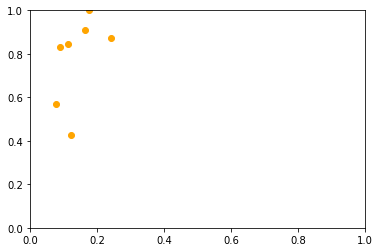

In [ ]:
# for each trip
fig, ax = plt.subplots()
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

for i in range(len(dive_real)):
    
    real = 1*(dive_real[i]>0)
    estim = 1*(dive_estim[i]>0)
    
    true_positive = np.mean(estim[real == 1])
    true_negative = 1-np.mean(estim[real == 0])

    ax.scatter(1-true_negative, true_positive, c = 'orange')
    
    print((true_positive, true_negative))

# ROC curve

Change the decision threshold

In [ ]:
# globally
TP = []
FP = []

all_real = 1* (np.hstack(dive_real)> 0)    
for tt in np.arange(-10, 10, 0.1):
    all_estim = 1* (np.hstack(dive_estim) > tt)
    true_positive = np.mean(all_estim[all_real == 1])
    true_negative = 1-np.mean(all_estim[all_real == 0])
    TP.append(true_positive)
    FP.append(1-true_negative)

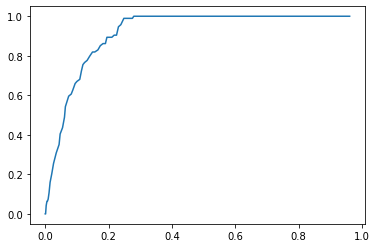

In [ ]:
plt.plot(np.array(FP), np.array(TP))

In [ ]:
data = {'model': 'deep_network_matrix',
        'FP':  FP,
        'TP': TP
        }

df = pd.DataFrame (data, columns = ['model','FP','TP'])

df.to_csv('./roc_deep_network_matrix.csv', index = False)
# df.to_csv('./roc/roc_deep_network_matrix.csv', index = False)